In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import re
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
import pandas as pd
import sklearn
import keras_tuner
from keras_nlp.layers import PositionEmbedding

# Reading Data

In [8]:
#df=pd.read_csv("/NAMESCREENING_1/X71uZTip/Processed_Names.csv")
import os
# Recipe inputs
folder_path = dataiku.Folder("Name Screening notebooks").get_path()  #/* FuShmlsH is the Folder ID */
path_of_csv = os.path.join(folder_path, "Processed_Names.csv") #/* dataset_01.csv is one of the files in this folder */
df=pd.read_csv(path_of_csv)
# df=pd.read_csv("Processed_Names.csv")


In [9]:
try :
    df.drop("Unnamed: 0",axis=1,inplace=True)
except:
    df
df

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE
0,"['', '', '', '', '', '', '', '', '', '', '', '...","['SAHARUDDIN BIN MD SALLEH', '', '', '']","['', '', '', '', '', '', 'SHARUDDIN BIN MD SAL...",Mismatch ID number_NRIC\n,FP,95.0
1,"['', '', '', '', '', '', '', '', '', '', '', '...","['HO KIONG CHAN', '', '', '']","['', '', '', '', '', '', 'HO KIONG CHAN']",NaN,TH,100.0
2,"['', '', '', '', '', '', '', '', '', '', '', '...","[' AHMAD ASABI BIN ISMAIL', '', '', '']","['', '', '', '', '', '', ' AHMAD ASABI BIN ISM...",NaN,TH,100.0
3,"['', '', '', '', '', '', '', '', '', '', '', '...","['ANG LEE ENG', '', '', '']","['', '', '', '', '', '', 'ANG LEE ENG']",Mismatch ID number_NRIC,FP,100.0
4,"['', '', '', '', '', '', '', '', '', '', '', '...","['ENG LEE ANG', '', '', '']","['', '', '', '', '', '', 'ANG LEE ENG']",Mismatch ID Number_NRIC,FP,100.0
...,...,...,...,...,...,...
715256,"['', '', '', '', '', '', '', '', '', '', '', '...","[' MUHD UMAR', '', '', '']","['', '', '', '', '', '', ' MUHD UMAIR']",Mismatch Full Legal Name – Name Does Not Sound...,FP,90.0
715257,"['', '', '', '', '', '', '', '', '', '', '', '...","[' MUHD UMAR', '', '', '']","['', '', '', '', '', '', ' MUHD UMAIR']",Mismatch Father's Name - Difference in Father'...,FP,90.0
715258,"['', '', '', '', '', '', '', '', '', '', '', '...","[' MUHD UMAIR', '', '', '']","['', '', '', '', '', '', ' MUHD UMAIR']",Mismatch Father's Name - Difference in Father'...,FP,100.0
715259,"['', '', '', '', '', '', '', '', '', '', '', '...","['MAIKO SUZUKI', '', '', '']","['', '', '', '', '', '', 'MARIKO SUZUKI']",Mismatch Full Legal Name_Name Does Not Sound S...,FP,93.0


In [10]:
print(df["ALL_ALIAS_NAMES"].apply(lambda x : type(x)).unique())
print(df["ALL_PARTY_NAMES"].apply(lambda x: type(x)).unique())
print(df["ALL_WL_NAMES"].apply(lambda x: type(x)).unique())

[<class 'str'>]
[<class 'str'>]
[<class 'str'>]


In [11]:
df["ALL_WL_NAMES"]

0         ['', '', '', '', '', '', 'SHARUDDIN BIN MD SAL...
1                 ['', '', '', '', '', '', 'HO KIONG CHAN']
2         ['', '', '', '', '', '', ' AHMAD ASABI BIN ISM...
3                   ['', '', '', '', '', '', 'ANG LEE ENG']
4                   ['', '', '', '', '', '', 'ANG LEE ENG']
                                ...                        
715256              ['', '', '', '', '', '', ' MUHD UMAIR']
715257              ['', '', '', '', '', '', ' MUHD UMAIR']
715258              ['', '', '', '', '', '', ' MUHD UMAIR']
715259            ['', '', '', '', '', '', 'MARIKO SUZUKI']
715260    ['LIUAYUAN YUAN', '', '', '', '', '', 'YUANYUA...
Name: ALL_WL_NAMES, Length: 715261, dtype: object

In [12]:
# need to remove brackets & split based on comma as whole input in complete one string.
list_col=["ALL_ALIAS_NAMES","ALL_PARTY_NAMES","ALL_WL_NAMES"]
def str_gen(col_nam):
    print(col_nam)
    df[col_nam]=df[col_nam].apply(lambda x: x.lstrip("[").rstrip("]"))
    df[col_nam]=df[col_nam].apply(lambda x : re.split(",",x))
    df[col_nam]=df[col_nam].apply(lambda x: [i.strip("\"").strip(' \'') for i in x])

for i in list_col:
    str_gen(i)

ALL_ALIAS_NAMES
ALL_PARTY_NAMES
ALL_WL_NAMES


In [13]:
df["ALL_WL_NAMES"]

0           [, , , , , , SHARUDDIN BIN MD SALLEH]
1                     [, , , , , , HO KIONG CHAN]
2            [, , , , , , AHMAD ASABI BIN ISMAIL]
3                       [, , , , , , ANG LEE ENG]
4                       [, , , , , , ANG LEE ENG]
                           ...                   
715256                   [, , , , , , MUHD UMAIR]
715257                   [, , , , , , MUHD UMAIR]
715258                   [, , , , , , MUHD UMAIR]
715259                [, , , , , , MARIKO SUZUKI]
715260    [LIUAYUAN YUAN, , , , , , YUANYUAN LIU]
Name: ALL_WL_NAMES, Length: 715261, dtype: object

In [14]:
print(df["ALL_ALIAS_NAMES"].apply(lambda x: type(x)).unique())
print(df["ALL_PARTY_NAMES"].apply(lambda x: type(x)).unique())
print(df["ALL_WL_NAMES"].apply(lambda x: type(x)).unique())


[<class 'list'>]
[<class 'list'>]
[<class 'list'>]


# Generation of training dataset

### Filtering alerts with resolution TH , THNM and comments have match names.

In [15]:
# case-1 comments with name match but may have or not name variations
'''
print(df[df["V_COMMENTSs"].str.contains("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched name\
Match_Name|Match_Full Legal Name")][["v_comments","v_regd_party_name","v_profile_name","v_resolution"]])


# case -2 comments with name match but have having name variations

print("alerts closed with TH resolution having name match as comments but having name variation", \
     df[(df["V_COMMENTS"].str.contains("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched name\
Match_Name|Match_Full Legal Name") )& (df["v_regd_party_name"]!=df["v_profile_name"])][["v_comments","v_regd_party_name","v_profile_name"]].shape)
'''


'\nprint(df[df["V_COMMENTSs"].str.contains("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched nameMatch_Name|Match_Full Legal Name")][["v_comments","v_regd_party_name","v_profile_name","v_resolution"]])\n\n\n# case -2 comments with name match but have having name variations\n\nprint("alerts closed with TH resolution having name match as comments but having name variation",      df[(df["V_COMMENTS"].str.contains("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched nameMatch_Name|Match_Full Legal Name") )& (df["v_regd_party_name"]!=df["v_profile_name"])][["v_comments","v_regd_party_name","v_profile_name"]].shape)\n'

In [16]:
df["V_COMMENTS"]=df["V_COMMENTS"].apply(lambda x: "" if pd.isna(x) else x)
# We assume that all the alerts that are close because of names anchor should have name as text in comments .Now secondly, 
# we need to check that when commenst contain name as string , whether the context of comment is alogned with resolution TH , THNM, FP.
# So we obtain value counts for TH, THNM & FP .Now check with existing observed comments like Match Full leagal name , to see what extent to we approach to these value counts.
patt=re.compile("name",re.IGNORECASE)
print(df[df["V_COMMENTS"].str.contains(patt,re.IGNORECASE)].shape)
print(df[df["V_COMMENTS"].str.contains(patt,re.IGNORECASE)]["V_RESOLUTION"].value_counts())


patt_2=re.compile("Match Full Legal Name|Match Name|Match_ Full Legal Name|Match name|Match_name|Matched Name|Matched name\
Match_Name|Match_Full Legal Name|Match ID and Full Legal Name|Match ID or Full Legal Name|Match ID & Legal Name|Match ID and/or Full Legal Name|Match_ Name|Match Full Legal  Name",re.IGNORECASE)

df_TH_comm_val=pd.DataFrame({})
df_TH_comm_val=df[(df["V_COMMENTS"].str.contains(patt_2)) & (df["V_RESOLUTION"].isin(["TH","THNM"]))]

print(df[(df["V_COMMENTS"].str.contains(patt_2)) & (df["V_RESOLUTION"].isin(["TH","THNM"]))].shape)

(195034, 6)
FP      127672
TH       65655
THNM      1707
Name: V_RESOLUTION, dtype: int64
(62599, 6)


We see that out of 69,035 alerts with comments as name & resolution TH, THNM we are able to validate for 64061.Refer jupyter noreboook Comment_Analysis_For_Names to see the alerts where comments cannot be validated.

### Filtering the alerts with resolution as FP and comments as name miss-match


In [17]:
df[(df["V_COMMENTS"].str.contains(patt)) & (df["V_RESOLUTION"]=="FP")].shape

(127672, 6)

In [18]:
# We need to check whether the context in which name is coming in comments is aligned with resolution FP.So we have existing 
# comments based on which we validate that upto how much alerts with name in comments & FP can we achieve.
patt_3=re.compile("Mismatch Full Legal Name|not sounds similar|not sound similar",re.IGNORECASE)
print(df[(df["V_COMMENTS"].str.contains(patt_3)) & (df["V_RESOLUTION"]=="FP")]["V_COMMENTS"].shape)
# Refer Comment_Analysis_For_Names to see the alerts where commenst could not be validated i.e 14 thousand alerts approx.

df_FP_comm_val=df[(df["V_COMMENTS"].str.contains(patt_3)) & (df["V_RESOLUTION"]=="FP")]

(113055,)


In [19]:
print(df_TH_comm_val.shape[0]+df_FP_comm_val.shape[0])
df_comm_val=pd.concat([df_TH_comm_val,df_FP_comm_val],axis=0,join="outer")
df_comm_val = df_comm_val.sample(frac=1, random_state=42).reset_index(drop=True)
df_comm_val.head()

175654


,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE
0,"[, , , , , , , , , , , , , , , ]","[ZHANG QIAN, , , ]","[, , , , , , QIANG ZHANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,91.0
1,"[, , , , , , , , , , , , , , , ]","[MUHD ANUAR BIN MOHD FAUZI, , , ]","[, , , , , , MUHD ANUAR BIN MOHD FAUZI]","Match Name, Gender, ID number_NRIC, Date of Bi...",TH,100.0
2,"[, , , , , , , , , , , , , , , ]","[TIN ZAW NAING, , , ]","[ZAW NAING, , , , , , ZAW NAING WIN]",Mismatch Full Legal Name_Name Does Not Sound S...,FP,93.0
3,"[, , , , , , , , , , , , , , , ]","[MUHD AZEEM, , , ]","[, , , , , , MUHD AZEEM]",Match Name and ID,TH,100.0
4,"[, , , , , , , , , , , , , , , ]","[WANG BIN, , , ]","[WANGAWEI QIN, , , , , , WANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,100.0


# Pre-processing

    Tokenizing 
    Text to Sequence
    Siamese Architechture
    Training & Call backs
    Graphical Analysis
    Random Search & Bayesian Optimization
    Best model
    Model prediction


### Tokenization

In [20]:
df_comm_val["WL_NAMES"]=df_comm_val["ALL_WL_NAMES"].apply(lambda x: x[6])
df_comm_val["PARTY_NAMES"]=df_comm_val["ALL_PARTY_NAMES"].apply(lambda x: x[0])

In [21]:
# Need to drop the alerts where any of the name is empty string.
print(df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))][["PARTY_NAMES","WL_NAMES"]].shape)
df_comm_val.drop(df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))].index,axis=0,inplace=True)

(8574, 2)


In [22]:
# none of them training data has customer or watchlist data empty
df_comm_val[ (df_comm_val["PARTY_NAMES"].isin([""])) | (df_comm_val["WL_NAMES"].isin([""]))][["PARTY_NAMES","WL_NAMES"]]

,PARTY_NAMES,WL_NAMES


In [23]:
df_comm_val

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE,WL_NAMES,PARTY_NAMES
0,"[, , , , , , , , , , , , , , , ]","[ZHANG QIAN, , , ]","[, , , , , , QIANG ZHANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,91.0,QIANG ZHANG,ZHANG QIAN
1,"[, , , , , , , , , , , , , , , ]","[MUHD ANUAR BIN MOHD FAUZI, , , ]","[, , , , , , MUHD ANUAR BIN MOHD FAUZI]","Match Name, Gender, ID number_NRIC, Date of Bi...",TH,100.0,MUHD ANUAR BIN MOHD FAUZI,MUHD ANUAR BIN MOHD FAUZI
2,"[, , , , , , , , , , , , , , , ]","[TIN ZAW NAING, , , ]","[ZAW NAING, , , , , , ZAW NAING WIN]",Mismatch Full Legal Name_Name Does Not Sound S...,FP,93.0,ZAW NAING WIN,TIN ZAW NAING
3,"[, , , , , , , , , , , , , , , ]","[MUHD AZEEM, , , ]","[, , , , , , MUHD AZEEM]",Match Name and ID,TH,100.0,MUHD AZEEM,MUHD AZEEM
4,"[, , , , , , , , , , , , , , , ]","[WANG BIN, , , ]","[WANGAWEI QIN, , , , , , WANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,100.0,WANG,WANG BIN
...,...,...,...,...,...,...,...,...
175649,"[, , , , , , , , , , , , , , , ]","[MUNIAN GOVINDASAMY, , , ]","[GOVINDASAMYAMUNIANDY AL, , , , , , MUNIANDY G...",Mismatch Full Legal Name_Name Does Not Sound S...,FP,90.0,MUNIANDY GOVINDASAMY,MUNIAN GOVINDASAMY
175650,"[, , , , , , , , , , , , , , , ]","[CHOO SIEW LAN, , , ]","[, , , , , , CHOO SIEW LAI]",Mismatch Full Legal Name – Name Does Not Sound...,FP,93.0,CHOO SIEW LAI,CHOO SIEW LAN
175651,"[, , , , , , , , , , , , , , , ]","[MAJIDAH ABDUL RAHMAN, , , ]","[, , , , , , RASIDAH AWANG ABDUL RAHMAN]",Mismatch Full Legal Name_ Name does not sounds...,FP,90.0,RASIDAH AWANG ABDUL RAHMAN,MAJIDAH ABDUL RAHMAN
175652,"[, , , , , , , , , , , , , , , ]","[CHEN YINZHI, , , ]","[CHENAJIN ZHI, , , , , , JINZHI CHEN]",Mismatch Full Legal Name_Native Name (Chinese ...,FP,91.0,JINZHI CHEN,CHEN YINZHI


In [24]:
import unicodedata

In [25]:
# check for  of unicode \xa0 in WL names and customer names

print(df_comm_val[df_comm_val["WL_NAMES"].str.contains("\\xa0")])
print(df_comm_val[df_comm_val["PARTY_NAMES"].str.contains("\\xa0")])


Empty DataFrame
Columns: [ALL_ALIAS_NAMES, ALL_PARTY_NAMES, ALL_WL_NAMES, V_COMMENTS, V_RESOLUTION, N_MATCH_SCORE, WL_NAMES, PARTY_NAMES]
Index: []
Empty DataFrame
Columns: [ALL_ALIAS_NAMES, ALL_PARTY_NAMES, ALL_WL_NAMES, V_COMMENTS, V_RESOLUTION, N_MATCH_SCORE, WL_NAMES, PARTY_NAMES]
Index: []


In [26]:
df_comm_val.shape

(167080, 8)

In [27]:
# check for duplicated data
df_comm_val[df_comm_val.duplicated(subset=["WL_NAMES","PARTY_NAMES","V_RESOLUTION"])].shape
# dropping duplicates
df_comm_val.drop_duplicates(subset=["WL_NAMES","PARTY_NAMES","V_RESOLUTION"], inplace=True)

In [28]:
df_comm_val.shape

(87287, 8)

In [29]:
file_path=os.path.join(folder_path,"Processed_names_for_training.csv")
df_comm_val[["PARTY_NAMES","WL_NAMES","V_RESOLUTION","V_COMMENTS","N_MATCH_SCORE"]].to_csv(file_path)

In [30]:
# Tokenizer - it means generating index for each token ( can be word or character) . So we need unique set of tokens


cust_and_wl_names = list(set(df_comm_val['PARTY_NAMES'].tolist()+\
                               df_comm_val['WL_NAMES'].tolist())) # list of list of unique set of names present in customer & watchlist data


tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK') # creating object of class tokenizer
tk.fit_on_texts(cust_and_wl_names)                              

tk.word_index

length = []

for i in range(len(cust_and_wl_names)):
    length.append(len(cust_and_wl_names[i]))
    
print(max(length))









84


In [31]:
tk.word_index.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [32]:
tk.word_index

{'UNK': 1,
 'a': 2,
 ' ': 3,
 'n': 4,
 'i': 5,
 'h': 6,
 'm': 7,
 'o': 8,
 'd': 9,
 'e': 10,
 'l': 11,
 'u': 12,
 'r': 13,
 's': 14,
 'b': 15,
 'g': 16,
 'k': 17,
 'z': 18,
 't': 19,
 'y': 20,
 'w': 21,
 'c': 22,
 'f': 23,
 'j': 24,
 'p': 25,
 'v': 26,
 'q': 27,
 'x': 28}

In [33]:


# construct a new vocabulary 

alphabet=''.join(list(tk.word_index.keys())).replace('UNK','')

char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
    
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict 
# Add 'UNK' to the vocabulary 
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1




In [34]:
char_dict

{'a': 1,
 ' ': 2,
 'n': 3,
 'i': 4,
 'h': 5,
 'm': 6,
 'o': 7,
 'd': 8,
 'e': 9,
 'l': 10,
 'u': 11,
 'r': 12,
 's': 13,
 'b': 14,
 'g': 15,
 'k': 16,
 'z': 17,
 't': 18,
 'y': 19,
 'w': 20,
 'c': 21,
 'f': 22,
 'j': 23,
 'p': 24,
 'v': 25,
 'q': 26,
 'x': 27,
 'UNK': 28}

In [35]:
input_dim=len(char_dict.keys())

In [36]:
tk

In [37]:
import pickle
path_of_obj=os.path.join(folder_path,"tk.sav")
pickle.dump(tk,open(path_of_obj,"wb"))

### Text to Sequence & Padding 

In [38]:
# convert names into sequences

### turning into Sequences & Padding
from keras_preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import pad_sequences
# -------------------
maxlen = max([51,len(np.max(df_comm_val['WL_NAMES'])),len(np.max(df_comm_val['PARTY_NAMES']))])

sequences_names_cust = tk.texts_to_sequences(df_comm_val['PARTY_NAMES'].tolist())
sequences_names_wl = tk.texts_to_sequences(df_comm_val['WL_NAMES'].tolist())


# Padding to 51
cust_pad_names = pad_sequences(sequences_names_cust, maxlen=maxlen, padding='post')
wl_pad_names = pad_sequences(sequences_names_wl, maxlen=maxlen, padding='post')




#df["ALL_WL_NAMES"].apply(lambda x: tk.texts_to_sequence(i))


In [39]:
# Convert to numpy array
cust_pad_names = np.array(cust_pad_names)
wl_pad_names = np.array(wl_pad_names)
#print(df_comm_val['ALL_PARTY_NAMES'].tolist()[1])
#print(cust_pad_names [1])

In [40]:
df_comm_val["V_RESOLUTION"].value_counts()

TH      44206
FP      42260
THNM      821
Name: V_RESOLUTION, dtype: int64

In [41]:
df_comm_val["Score"]=df_comm_val["V_RESOLUTION"].apply(lambda x: 1 if x in ["TH","THNM"] else 0 )

In [42]:
try:
    df_comm_val.drop("Unnamed: 0",axis=1,inplace=True)
except:
    df_comm_val
df_comm_val

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE,WL_NAMES,PARTY_NAMES,Score
0,"[, , , , , , , , , , , , , , , ]","[ZHANG QIAN, , , ]","[, , , , , , QIANG ZHANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,91.0,QIANG ZHANG,ZHANG QIAN,0
1,"[, , , , , , , , , , , , , , , ]","[MUHD ANUAR BIN MOHD FAUZI, , , ]","[, , , , , , MUHD ANUAR BIN MOHD FAUZI]","Match Name, Gender, ID number_NRIC, Date of Bi...",TH,100.0,MUHD ANUAR BIN MOHD FAUZI,MUHD ANUAR BIN MOHD FAUZI,1
2,"[, , , , , , , , , , , , , , , ]","[TIN ZAW NAING, , , ]","[ZAW NAING, , , , , , ZAW NAING WIN]",Mismatch Full Legal Name_Name Does Not Sound S...,FP,93.0,ZAW NAING WIN,TIN ZAW NAING,0
3,"[, , , , , , , , , , , , , , , ]","[MUHD AZEEM, , , ]","[, , , , , , MUHD AZEEM]",Match Name and ID,TH,100.0,MUHD AZEEM,MUHD AZEEM,1
4,"[, , , , , , , , , , , , , , , ]","[WANG BIN, , , ]","[WANGAWEI QIN, , , , , , WANG]",Mismatch Full Legal Name – Name Does Not Sound...,FP,100.0,WANG,WANG BIN,0
...,...,...,...,...,...,...,...,...,...
175640,"[, , , , , , , , , , , , , , , ]","[DORATY BAINGKIT, , , ]","[, , , , , , DORATY BAINGKIT]",SCC2: Match ID and/or Full Legal Name,TH,100.0,DORATY BAINGKIT,DORATY BAINGKIT,1
175643,"[, , , , , , , , , , , , , , , ]","[MOHD FIRDAUS BIN HASSAN, , , ]","[, , , , , , MUHD FIRDHAUS BIN HASSAN]","Mismatch - Name, Date of birth\n\nCustomer - a...",FP,90.0,MUHD FIRDHAUS BIN HASSAN,MOHD FIRDAUS BIN HASSAN,0
175647,"[, , , , , , , , , , , , , , , ]","[JOHN RON ROGER, , , ]","[, , , , , , JOHN RON ROGER]",Match ID and/or Full Legal Name,TH,100.0,JOHN RON ROGER,JOHN RON ROGER,1
175649,"[, , , , , , , , , , , , , , , ]","[MUNIAN GOVINDASAMY, , , ]","[GOVINDASAMYAMUNIANDY AL, , , , , , MUNIANDY G...",Mismatch Full Legal Name_Name Does Not Sound S...,FP,90.0,MUNIANDY GOVINDASAMY,MUNIAN GOVINDASAMY,0


In [43]:
df.shape

(715261, 6)

### Contrastive Loss

In [44]:
### defining contrastive loss

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [45]:
class cont_loss:
    def __init__(self):
        pass
    
    def loss(margin=1):
    
        def contrastive_loss(y_true, y_pred):

            y_pred = tf.cast(y_pred, tf.float32)
            y_true = tf.cast(y_true, tf.float32)

            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
            return tf.math.reduce_mean(
                (1 - y_true) * square_pred + (y_true) * margin_square
            )

        return contrastive_loss

In [46]:
#train_test_split()
X=np.array([[i,j]for (i,j) in zip(cust_pad_names,wl_pad_names) ])
y=df_comm_val["Score"].values

In [47]:
X[0]

array([[17,  5,  1,  3, 15,  2, 26,  4,  1,  3,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [26,  4,  1,  3, 15,  2, 17,  5,  1,  3, 15,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0]], dtype=int32)

In [48]:
tk.sequences_to_texts([np.delete(X[0,0],np.where(np.any(0 in X[0,0] or 28 in X[0,0])))])

Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


['i UNK   b a v n UNK   x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x']

In [49]:
np.delete(X[0,0],np.where(np.any(0 in X[0,0] or 28 in X[0,0])))

array([ 5,  1,  3, 15,  2, 26,  4,  1,  3,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [50]:
tk.word_index

{'a': 1,
 ' ': 2,
 'n': 3,
 'i': 4,
 'h': 5,
 'm': 6,
 'o': 7,
 'd': 8,
 'e': 9,
 'l': 10,
 'u': 11,
 'r': 12,
 's': 13,
 'b': 14,
 'g': 15,
 'k': 16,
 'z': 17,
 't': 18,
 'y': 19,
 'w': 20,
 'c': 21,
 'f': 22,
 'j': 23,
 'p': 24,
 'v': 25,
 'q': 26,
 'x': 27,
 'UNK': 28}

# Train-test split

In [51]:
# we split the dataset becoz we don't want any input from test dataset in tokenization & training of model 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=2)

In [52]:
X_train.shape

(70702, 2, 51)

In [53]:
train_cust_names=X_train[:,0]
train_wl_names=X_train[:,1]
test_cust_names=X_test[:,0]
test_wl_names=X_test[:,1]

val_cust_names=X_val[:,0]
val_wl_names=X_val[:,1]

In [54]:
test_cust_names.shape

(8729, 51)

In [55]:
print("the count of rows with nith name match in test dataset",sum(y_test==1))
print("the count of rows with name miss-match in test dataset",sum(y_test==0))



the count of rows with nith name match in test dataset 4510
the count of rows with name miss-match in test dataset 4219


In [56]:
print("rows in training data",y_train.shape)
print("rows in validation data",y_val.shape)
print("rows in  test data",y_test.shape)

rows in training data (70702,)
rows in validation data (7856,)
rows in  test data (8729,)


In [57]:
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
from keras.layers import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D

#pip install keras_nlp
#from keras_nlp.layers import PositionEmbedding


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
'''
embedded_l=tf.convert_to_tensor(np.array([embedded_l1,embedded_l2 ]))
embedded_l

#import tf.keras.layers.Conv1D

C_l = tf.keras.layers.Conv1D(filters = 32,                                # ---------layer2 ( Conv1d layer)
                            kernel_size = 1,
                            padding = 'valid',
                            activation = 'relu',kernel_initializer='he_uniform')(embedded_l)
'''

"\nembedded_l=tf.convert_to_tensor(np.array([embedded_l1,embedded_l2 ]))\nembedded_l\n\n#import tf.keras.layers.Conv1D\n\nC_l = tf.keras.layers.Conv1D(filters = 32,                                # ---------layer2 ( Conv1d layer)\n                            kernel_size = 1,\n                            padding = 'valid',\n                            activation = 'relu',kernel_initializer='he_uniform')(embedded_l)\n"

# Model Architechture

In [59]:
import tensorflow as tf
import keras
tf.random.set_seed(
    11
)

rate = 0.2

output_dim = 100

#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from tensorflow import one_hot

#OHE = one_hot(depth=100)
# Define inputs 
left_input = Input((51,))
right_input = Input((51,))

embedded_l = Embedding(30, output_dim)(left_input)                        #   ------layer 1 (embedding layer)
embedded_r = Embedding(30, output_dim)(right_input)

'''
OHE_embeddings_l = one_hot(embedded_l, 100)
OHE_embeddings_r = one_hot(embedded_r, 100)

embedded_l = embedded_l + OHE_embeddings_l
embedded_r = embedded_r + OHE_embeddings_r
'''
position_embeddings_l = PositionEmbedding(
    sequence_length=51)(embedded_l)
position_embeddings_r = PositionEmbedding(
    sequence_length=51)(embedded_r)

embedded_l = embedded_l + position_embeddings_l
embedded_r = embedded_r + position_embeddings_r

# 
C_l = tf.keras.layers.Conv1D(filters = 100,                                # ---------layer2 ( Conv1d layer)
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'relu',kernel_initializer='he_uniform')(embedded_l)
C_r = tf.keras.layers.Conv1D(filters = 100,                                # ---------layer2 ( Conv1d layer)
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'relu',kernel_initializer='he_uniform')(embedded_r)
C_l = Dense(output_dim)(C_l)                                             # ----------------layer3 ( dense layer)
C_r = Dense(output_dim)(C_r)

C_l = embedded_l + C_l                                                   # updating vector
C_r = embedded_r + C_r

##

C_l = tf.keras.layers.Dropout(rate)(C_l)                                # -----------------layer 4 ( dropout layer)
C_r = tf.keras.layers.Dropout(rate)(C_r)

C_l = embedded_l + C_l                                                 # updating vector
C_r = embedded_r + C_r


##
""

#C_r.add(tf.keras.layers.SpatialDropout1D(rate))

""
"""
C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 6,
                            padding = 'same',
                            activation = 'relu')(C_l)

   """                      #   """kernel_regularizer=regularizers.L2(l2=1e-5),
                         #   bias_regularizer=regularizers.L1(1e-5),
                         #   activity_regularizer=regularizers.L2(1e-2)"""
"""                            
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'relu')(C_r)

"""                         #   """kernel_regularizer=regularizers.L2(l2=1e-5),
                         #   bias_regularizer=regularizers.L1(1e-5),
                         #   activity_regularizer=regularizers.L2(1e-2)"""
                            
"""
C_l = Dense(output_dim)(C_l)
C_r = Dense(output_dim)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r
"""
""
##
"""
C_l = tf.keras.layers.Dropout(rate)(C_l)
C_r = tf.keras.layers.Dropout(rate)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

"""
##

"""
C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'relu')(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'relu')(C_r)

C_l = Dense(output_dim)(C_l)
C_r = Dense(output_dim)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

"""
""
# Generate C_l & C_r with regularization - kernel,bias,activity                  # layer5 ( Conv1d)
C_l = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'relu',kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.L2(l2=1e-5),
                            bias_regularizer=regularizers.L1(1),
                            activity_regularizer=regularizers.L2(1e-2))(C_l)
C_r = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'relu',kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.L2(l2=1e-5),
                            bias_regularizer=regularizers.L1(1),
                            activity_regularizer=regularizers.L2(1e-2))(C_r)
# Adding dense layer with nuerons equal to 64

C_l = Dense(output_dim)(C_l)                                                      #layer6 (dense layer)
C_r = Dense(output_dim)(C_r)

# Summing the input  embed & output of dense layer 
C_l = embedded_l + C_l                                                           # update 
C_r = embedded_r + C_r

##
"""
C_l = tf.keras.layers.Dropout(rate)(C_l)
C_r = tf.keras.layers.Dropout(rate)(C_r)

C_l = embedded_l + C_l
C_r = embedded_r + C_r

"""
##


# Adding dense layer with one nueron. 

C_l = Dense(1)(C_l)                                                                       # layer7 (dense layer)
C_r = Dense(1)(C_r)

                                                        # return the cosine similarity on output of left & right sub-network
y_pred = Dot(axes=(1), normalize=True)([C_l, C_r]) # y_pred == E_w
                                                                                          # flattening
y_pred = Flatten()(y_pred)
# one final neuron with sigmoid as activation.
y_pred = tf.keras.layers.Dense(1, activation="sigmoid")(y_pred)                           # layer 8 (output layer)

# define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


siamese_net_4_mod_1 = Model(inputs=[left_input,right_input],outputs=y_pred)
#siamese_net_4_mod_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, \
siamese_net_4_mod_1.compile(loss=loss(margin=1), optimizer=opt, \
                      metrics=[tf.keras.metrics.Precision(thresholds=0.5),tf.keras.metrics.Recall(thresholds=0.5)])


print(siamese_net_4_mod_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 51, 100)              3000      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 51, 100)              3000      ['input_2[0][0]']             
                                                                                              

In [60]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()

# Training

In [61]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [\
      EarlyStopping(monitor='val_loss', min_delta =0.01, patience=25, mode='min'),\
      ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=10, min_lr=0.000001),\
      ModelCheckpoint(filepath=os.path.join(folder_path,"mixed_val_loss_ind_pe.hdf5"),
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True,
                      save_weights_only=False,
                      mode='min',
                      )]
history = siamese_net_4_mod_1.fit(x=[train_cust_names,train_wl_names],y=y_train,validation_data=([val_cust_names,val_wl_names],y_val),
                       epochs = 30,
                       verbose = 1,
                       shuffle = True,
                       callbacks=[keras_callbacks])

Epoch 1/30
2207/2210 [============================>.] - ETA: 0s - loss: 0.2316 - precision: 0.6327 - recall: 0.9673
Epoch 1: val_loss improved from inf to 0.20938, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_ind_pe.hdf5
2210/2210 [==============================] - 36s 15ms/step - loss: 0.2315 - precision: 0.6328 - recall: 0.9673 - val_loss: 0.2094 - val_precision: 0.6871 - val_recall: 0.9682 - lr: 1.0000e-04
Epoch 2/30
   5/2210 [..............................] - ETA: 32s - loss: 0.2011 - precision: 0.7395 - recall: 0.9670

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


2208/2210 [============================>.] - ETA: 0s - loss: 0.2010 - precision: 0.7243 - recall: 0.9530
Epoch 2: val_loss improved from 0.20938 to 0.19567, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_ind_pe.hdf5
2210/2210 [==============================] - 32s 15ms/step - loss: 0.2010 - precision: 0.7243 - recall: 0.9529 - val_loss: 0.1957 - val_precision: 0.7289 - val_recall: 0.9454 - lr: 1.0000e-04
Epoch 3/30
2207/2210 [============================>.] - ETA: 0s - loss: 0.1889 - precision: 0.7420 - recall: 0.9451
Epoch 3: val_loss improved from 0.19567 to 0.18369, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_ind_pe.hdf5
2210/2210 [==============================] - 30s 14ms/step - loss: 0.1889 - precision: 0.7420 - recall: 0.9451 - val_loss: 0.1837 - val_precision: 0.7399 - val_recall: 0.9542 - lr: 1.0000e-04
Epoch 4/30
2208/2210 [============================>.] - ETA: 0s - loss: 0.1759 - precision:

In [62]:
model_path=os.path.join(folder_path,"mixed_val_loss_ind_pe.hdf5")
tf.keras.models.load_model(model_path,compile=False)

In [63]:
# metrics on test dataset
y_pred=siamese_net_4_mod_1.predict([test_cust_names,test_wl_names])

273/273 [==============================] - 2s 5ms/step


# SCORE GENERATION

In [66]:
def score_generation(x,y):
    if x=="" or y=="":
        return 0
    else:
        sequences_names_cust=tk.texts_to_sequences([x])
        sequences_names_wl=tk.texts_to_sequences([y])
        cust_pad_names = pad_sequences(sequences_names_cust, maxlen, padding='post')
        wl_pad_names = pad_sequences(sequences_names_wl, maxlen, padding='post')
        cust_pad_names = np.array(cust_pad_names)
        wl_pad_names = np.array(wl_pad_names)
        return siamese_net_4_mod_1.predict([cust_pad_names,wl_pad_names])[0][0]

In [67]:
# check for name variations
#exact names
print(score_generation("Siddharth Gupta","Siddharth Gupta"),"Siddharth Gupta","Siddharth Gupta")
# spaces and hypens
print(score_generation("Siddharth Gupta","Siddharth-Gupta"),"Siddharth Gupta","Siddharth-Gupta")
print(score_generation("Siddharth Gupta","SiddharthGupta"),"Siddharth Gupta","SiddharthGupta")
# out of order
print(score_generation("Siddharth Gupta","Gupta Siddharth"),"Siddharth Gupta","Gupta Siddharth")

# missing word component
print(score_generation("Kamlesh Kumar Singh","Kamlesh Singh"),"Kamlesh Kumar Singh","Kamlesh Singh")
# Truncated similiar names
print(score_generation("Siddharth Gupta","Sid Gupta"),"Siddharth Gupta","Sid Gupta")

# truncated and out of order component
print(score_generation("Siddharth Gupta","Gupta Sid"),"Siddharth Gupta","Gupta Sid")
# truncated and missing word component
print(score_generation("Kamlesh Kumar Singh","Singh Kamlesh"),"Kamlesh Kumar Singh","Singh Kamlesh")

1/1 [==============================] - 0s 22ms/step
0.8962383 Siddharth Gupta Siddharth Gupta
1/1 [==============================] - 0s 22ms/step
0.896259 Siddharth Gupta Siddharth-Gupta
1/1 [==============================] - 0s 24ms/step
0.06880779 Siddharth Gupta SiddharthGupta
1/1 [==============================] - 0s 23ms/step
0.115648754 Siddharth Gupta Gupta Siddharth
1/1 [==============================] - 0s 22ms/step
0.68486863 Kamlesh Kumar Singh Kamlesh Singh
1/1 [==============================] - 0s 25ms/step
0.11166333 Siddharth Gupta Sid Gupta
1/1 [==============================] - 0s 22ms/step
0.12393254 Siddharth Gupta Gupta Sid
1/1 [==============================] - 0s 21ms/step
0.19850382 Kamlesh Kumar Singh Singh Kamlesh


In [84]:
y_pred.shape

(8744, 1)

In [85]:
threshold=0.5
y_pred_binary_score=np.array([ 1 if i>threshold else 0 for i in y_pred.flatten()])

In [86]:
recall=tf.keras.metrics.Recall(thresholds=0.5)

In [87]:
recall.update_state(y_test,y_pred)
recall_value = recall.result().numpy()

In [88]:
recall_value

0.917613

In [89]:
precision=tf.keras.metrics.Precision(thresholds=0.5)
precision.update_state(y_test,y_pred)
precision_value = precision.result().numpy()

In [90]:
precision_value

0.8740191

In [91]:
siamese_net_4_mod_1.predict([test_cust_names,test_wl_names])

274/274 [==============================] - 1s 5ms/step


array([[0.6415718 ],
       [0.01102902],
       [0.05983183],
       ...,
       [0.90826786],
       [0.76519495],
       [0.05551093]], dtype=float32)

In [92]:
# investigation on test datasets for checking the match of predicted value and test value when names of both profiles are same
results_on_test_when_same_name=siamese_net_4_mod_1.predict([test_cust_names[np.where(y_test==1)],test_wl_names[np.where(y_test==1)]])
pd.DataFrame(results_on_test_when_same_name).describe()

141/141 [==============================] - 1s 5ms/step


the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


,0
count,4491.000000
mean,0.796519
std,0.184340
min,0.003059
25%,0.783597
50%,0.872271
75%,0.901972
max,0.928401


In [93]:
results_on_test_when_same_name,y_pred

(array([[0.6415718],
        [0.9055902],
        [0.8371424],
        ...,
        [0.9121064],
        [0.8864029],
        [0.908268 ]], dtype=float32),
 array([[0.6415718 ],
        [0.01102902],
        [0.05983183],
        ...,
        [0.90826786],
        [0.76519495],
        [0.05551093]], dtype=float32))

<function matplotlib.pyplot.show(close=None, block=None)>

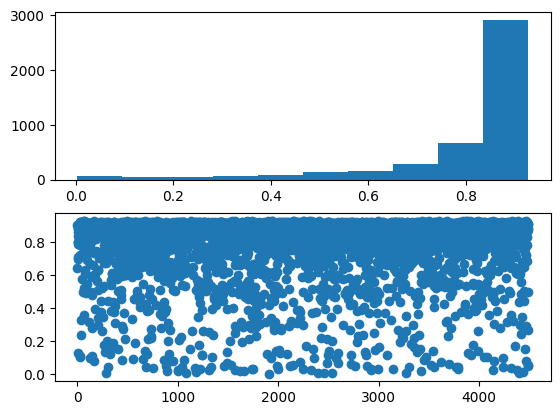

In [94]:
fig,ax=plt.subplots(nrows=2,ncols=1)
#plt.scatter(np.arange(len(results_on_test_when_same_name)),results_on_test_when_same_name)
ax[0].hist(results_on_test_when_same_name,10)
ax[1].scatter(np.arange(len(results_on_test_when_same_name)),results_on_test_when_same_name)

plt.show

In [95]:
# investigation on test datapoints when customer and watchlist name miss-match
results_on_test_when_diff_name=siamese_net_4_mod_1.predict([test_cust_names[np.where(y_test==0)],test_wl_names[np.where(y_test==0)]])
pd.DataFrame(results_on_test_when_diff_name).describe()

133/133 [==============================] - 1s 4ms/step


the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


,0
count,4253.000000
mean,0.199911
std,0.236946
min,0.001695
25%,0.035021
50%,0.091652
75%,0.273082
max,0.928837


<function matplotlib.pyplot.show(close=None, block=None)>

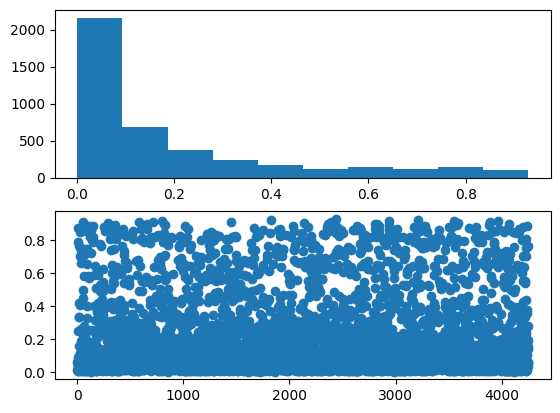

In [96]:
fig,ax=plt.subplots(nrows=2,ncols=1)

ax[0].hist(results_on_test_when_diff_name,10)
ax[1].scatter(np.arange(len(results_on_test_when_diff_name)),results_on_test_when_diff_name)

plt.show

### Graphical Analysis

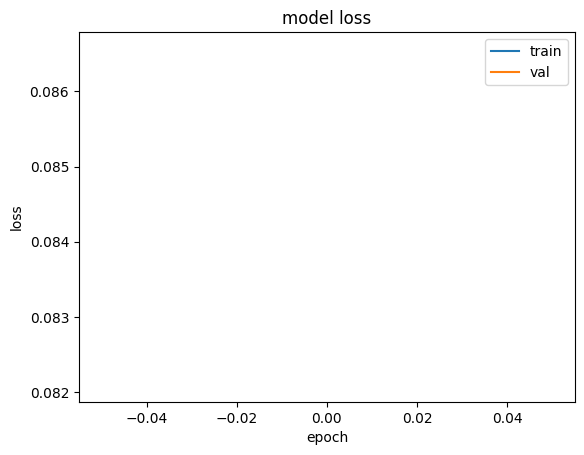

In [97]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [98]:
history.history.keys()


dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall', 'lr'])

We conclude that after 20 epochs val loss comes to saturation meanwhile train loss may go down increasing possiblity of 
overfitting

KeyError: 'precision_5'

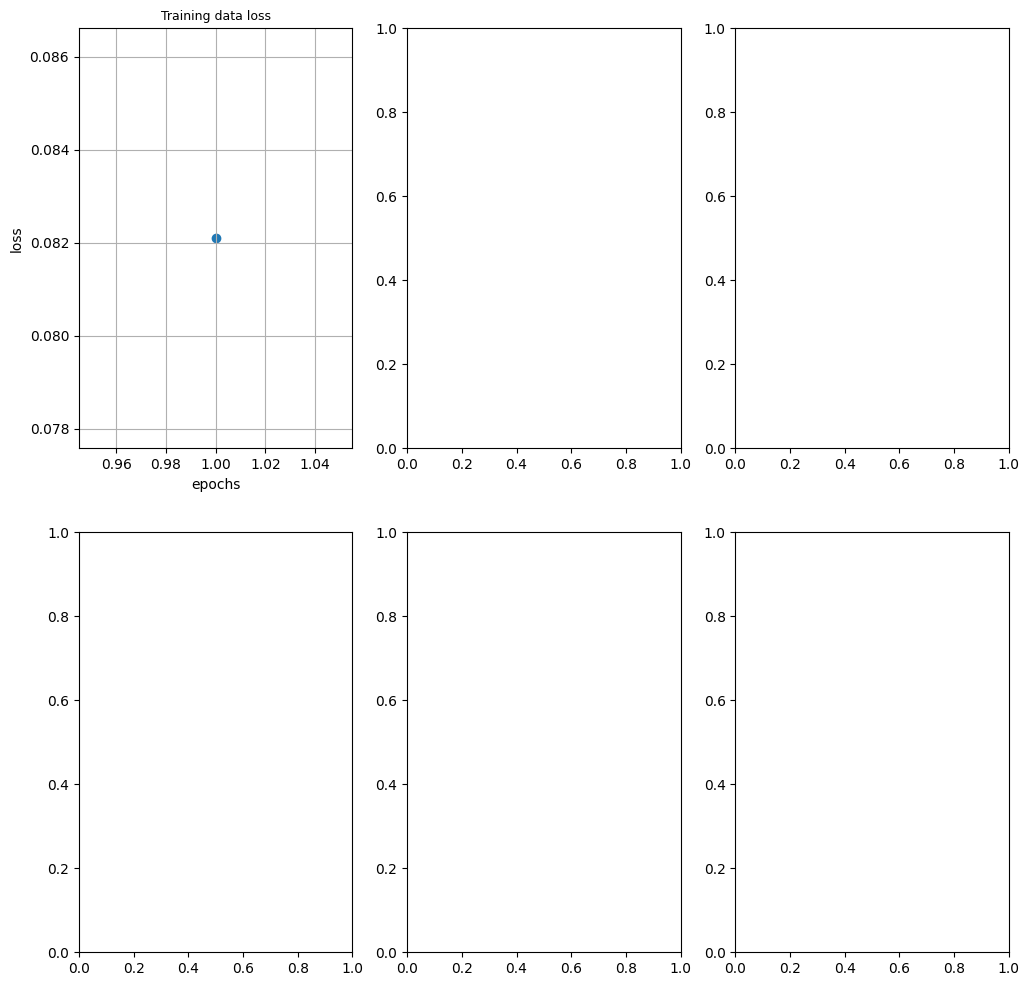

In [99]:
N_epochs=len(history.history['loss'])
fig,ax=plt.subplots(nrows=2,ncols=3,squeeze=False,figsize=(12,12))
plt.sca(ax[0,0])
ax[0,0].scatter(range(1,N_epochs+1),history.history['loss'])

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training data loss",fontsize=9)
plt.grid()

plt.sca(ax[0,1])
ax[0,1].scatter(range(1,N_epochs+1),history.history['precision_5'])
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Precision",fontsize=9)
plt.grid()

plt.sca(ax[0,2])
ax[0,2].scatter(range(1,N_epochs+1),history.history['recall_5'])
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Recall",fontsize=9)
plt.grid()


plt.sca(ax[1,1])
ax[1,1].scatter(range(1,N_epochs+1),history.history['val_precision_5'])
plt.xlabel("epochs")
plt.ylabel("Val_Precision")
plt.title("Val_Precision",fontsize=9)
plt.grid()

plt.sca(ax[1,2])
ax[1,2].scatter(range(1,N_epochs+1),history.history['val_recall_5'])
plt.xlabel("epochs")
plt.ylabel("Val_Recall")
plt.title("Val_Recall",fontsize=9)
plt.grid()
                                                    
plt.sca(ax[1,0])
ax[1,0].scatter(range(1,N_epochs+1),history.history['val_loss'],color="orange")

plt.xlabel("epochs")
plt.ylabel("val_loss")
plt.title("Validation data loss",fontsize=9)
plt.grid()
fig.tight_layout()
plt.show()

### Prediction on Test  data

In [100]:
y_test

array([1, 0, 0, ..., 1, 0, 0])

In [101]:
# metrics on test dataset
y_pred=siamese_net_4_mod_1.predict([test_cust_names,test_wl_names])

274/274 [==============================] - 2s 6ms/step


In [102]:
y_pred

array([[0.6415718 ],
       [0.01102902],
       [0.05983183],
       ...,
       [0.90826786],
       [0.76519495],
       [0.05551093]], dtype=float32)

In [103]:
delta=abs(y_test-y_pred.flatten())

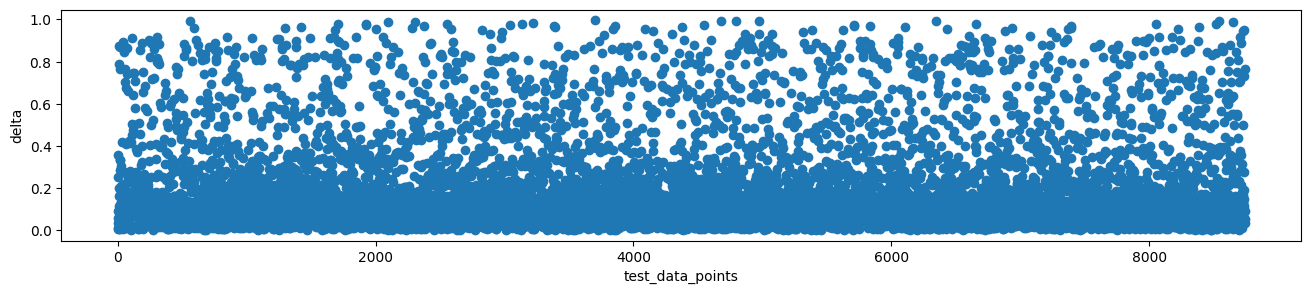

In [104]:
fig,ax=plt.subplots(figsize=(16,3))
plt.scatter(range(len(delta)),delta)
plt.xlabel("test_data_points")
plt.ylabel("delta")
plt.show()

### Prediction on test dataset

In [105]:
y_pred=np.array([1 if i>=0.5 else 0 for i in y_pred])

In [106]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
print("Confusion matrix \n\n",confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4253
           1       0.87      0.92      0.90      4491

    accuracy                           0.89      8744
   macro avg       0.89      0.89      0.89      8744
weighted avg       0.89      0.89      0.89      8744

Confusion matrix 

 [[3659  594]
 [ 370 4121]]


In [108]:
[train_cust_names,train_wl_names]

[array([[ 6,  3,  8, ...,  0,  0,  0],
        [17,  5,  1, ...,  0,  0,  0],
        [ 6, 10,  5, ...,  0,  0,  0],
        ...,
        [ 6,  1, 17, ...,  0,  0,  0],
        [ 6,  7,  5, ...,  0,  0,  0],
        [ 1, 14,  8, ...,  0,  0,  0]], dtype=int32),
 array([[ 6,  3,  8, ...,  0,  0,  0],
        [ 5,  9,  4, ...,  0,  0,  0],
        [ 6, 10,  5, ...,  0,  0,  0],
        ...,
        [ 1, 17,  3, ...,  0,  0,  0],
        [ 6,  7,  5, ...,  0,  0,  0],
        [ 1, 14,  8, ...,  0,  0,  0]], dtype=int32)]

### Prediction on training data

In [109]:
y_pred_train=siamese_net_4_mod_1.predict([train_cust_names,train_wl_names])

2214/2214 [==============================] - 12s 5ms/step


In [110]:
y_pred_train=np.array([1 if i>=0.5 else 0 for i in y_pred_train])

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     34351
           1       0.89      0.94      0.91     36475

    accuracy                           0.91     70826
   macro avg       0.91      0.90      0.91     70826
weighted avg       0.91      0.91      0.91     70826



In [112]:
# We see that the difference b/w the metrics atmost lies to 0.06. So fairly there is no overfitting happening.We require f1 score .It is is fairly good.Based on recall on 
# on 0 as major target value we can see that on test data 

### Prediction on Validation data

In [115]:
y_val

array([0, 0, 0, ..., 1, 1, 1])

In [116]:
y_pred_val=siamese_net_4_mod_1.predict([val_cust_names,val_wl_names])
y_pred_val_binary= np.array([1 if i>=0.5 else 0 for i in y_pred_val])

246/246 [==============================] - 2s 6ms/step


In [117]:
print(classification_report(y_val,y_pred_val_binary))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3796
           1       0.87      0.92      0.90      4074

    accuracy                           0.89      7870
   macro avg       0.89      0.89      0.89      7870
weighted avg       0.89      0.89      0.89      7870



In [119]:
val_results=pd.DataFrame({"truth_val":y_val,"pred_val":y_pred_val_binary})
val_results["match"]=val_results[["truth_val","pred_val"]].apply(lambda x: 1 if x[0]==x[1] else 0,axis=1)
print(val_results["match"].value_counts())
val_results

1    6994
0     876
Name: match, dtype: int64


,truth_val,pred_val,match
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,1,1,1
...,...,...,...
7865,1,0,0
7866,1,1,1
7867,1,1,1
7868,1,1,1


In [120]:
y_val.shape

(7870,)

In [122]:
# loading Siamese model object
# loading Siamese model object
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")
#model_object=tf.keras.models.load_model(model_path)

# Random Search

In [126]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
def build_model(hp):


    rate = 0.2
    tf.random.set_seed(
        11
    )

    rate = 0.2

    output_dim = 100

    #from tensorflow.keras import layers
    from tensorflow.keras import regularizers
    from sklearn.preprocessing import OneHotEncoder
    from tensorflow import one_hot

    #OHE = one_hot(depth=100)
    # Define inputs 
    left_input = Input((51,))
    right_input = Input((51,))

    embedded_l = Embedding(51, output_dim)(left_input)                        #   ------layer 1 (embedding layer)
    embedded_r = Embedding(51, output_dim)(right_input)


    position_embeddings_l = PositionEmbedding(sequence_length=51)(embedded_l)
    position_embeddings_r = PositionEmbedding(sequence_length=51)(embedded_r)

    embedded_l = embedded_l + position_embeddings_l
    embedded_r = embedded_r + position_embeddings_r

    C_l =tf.keras.layers.Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
                                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                padding = 'same',
                                activation = 'relu',kernel_initializer='he_uniform')(embedded_l)
    
    C_r = tf.keras.layers.Conv1D(    # #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform')(embedded_r)

    C_l = Dense(output_dim)(C_l)                                             # ----------------layer3 ( dense layer)
    C_r = Dense(output_dim)(C_r)

    C_l = embedded_l + C_l                                                   # updating vector
    C_r = embedded_r + C_r

    ##

    C_l = tf.keras.layers.Dropout(rate)(C_l)                                # -----------------layer 4 ( dropout layer)
    C_r = tf.keras.layers.Dropout(rate)(C_r)

    C_l = embedded_l + C_l                                                 # updating vector
    C_r = embedded_r + C_r



    # Generate C_l & C_r with regularization - kernel,bias,activity                  # layer5 ( Conv1d)
    C_l = tf.keras.layers.Conv1D(filters=hp.Int('conv_2_filter', min_value=8, max_value=64, step=8),
        # adding filter size or kernel size
                                 kernel_size=hp.Choice('conv_2_kernel', values = [3,8]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.L2(l2=1e-5),
                                 bias_regularizer=regularizers.L1(1),
                                 activity_regularizer=regularizers.L2(1e-2))(C_l)
    C_r = tf.keras.layers.Conv1D(filters=hp.Int('conv_2_filter', min_value=8, max_value=64, step=8),
        # adding filter size or kernel size
                                 kernel_size=hp.Choice('conv_2_kernel', values = [3,8]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.L2(l2=1e-5),
                                 bias_regularizer=regularizers.L1(1),
                                 activity_regularizer=regularizers.L2(1e-2))(C_r)
    # Adding dense layer with nuerons equal to 64

    C_l = Dense(output_dim)(C_l)                                                      #layer6 (dense layer)
    C_r = Dense(output_dim)(C_r)

    # Summing the input  embed & output of dense layer 
    C_l = embedded_l + C_l                                                           # update 
    C_r = embedded_r + C_r


    ##


    # Adding dense layer with one nueron. 

    C_l = Dense(1)(C_l)                                                                       # layer7 (dense layer)
    C_r = Dense(1)(C_r)

    # return the cosine similarity on output of left & right sub-network
    y_pred = Dot(axes=(1), normalize=True)([C_l, C_r]) # y_pred == E_w
    # flattening
    y_pred = Flatten()(y_pred)
    # one final neuron with sigmoid as activation.
    y_pred = tf.keras.layers.Dense(1, activation="sigmoid")(y_pred)                           # layer 8 (output layer)

    # define optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    
    model = Model(inputs=[left_input,right_input],outputs=y_pred)
    #siamese_net_4_mod_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, \
    
    
    
    
    model.compile(loss=loss(), optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), \
                                metrics=[tf.keras.metrics.Precision(thresholds=0.5),tf.keras.metrics.Recall(thresholds=0.5)])

    return model
    

In [127]:
import keras_tuner
tuner_rs = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    project_name="Name_Matching",
    directory="tuner_01",
    max_trials=15)


In [128]:
#best_model = tuner.get_best_models(2)
tuner_rs.search_space_summary()

Search space summary
Default search space size: 5
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 8], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [130]:
tuner_rs.search([train_cust_names,train_wl_names],y_train, epochs=10, validation_data=([val_cust_names,val_wl_names],y_val),batch_size=500)

Trial 15 Complete [00h 02m 23s]
val_loss: 0.16514073312282562

Best val_loss So Far: 0.09921715408563614
Total elapsed time: 00h 29m 28s


In [131]:
tuner_rs.results_summary()

Results summary
Results in tuner_01/Name_Matching
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
conv_2_filter: 8
conv_2_kernel: 3
learning_rate: 0.01
Score: 0.09921715408563614

Trial 11 summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 3
conv_2_filter: 8
conv_2_kernel: 3
learning_rate: 0.01
Score: 0.10310964286327362

Trial 08 summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 16
conv_2_kernel: 3
learning_rate: 0.01
Score: 0.1178521066904068

Trial 05 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 3
conv_2_filter: 24
conv_2_kernel: 3
learning_rate: 0.01
Score: 0.12932991981506348

Trial 13 summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 3
conv_2_filter: 8
conv_2_kernel: 8
learning_rate: 0.001
Score: 0.1356419324874878

Trial 07 summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 3
conv_2_filter: 40
conv_2_kernel: 8
learning_rate: 0.001

In [132]:
# Get the top 2 models.
models_rs = tuner_rs.get_best_models(num_models=2)
best_model_rs = models_rs[0]


In [133]:
best_model_rs

In [134]:
model_path_rs=os.path.join(folder_path,"Siamese_RS_best_model_pe.hdf5")
tf.keras.models.save_model(best_model_rs, model_path_rs)

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


# re-train the model

In [111]:
# Get the top 2 hyperparameters.
best_hps_rs = tuner_rs.get_best_hyperparameters(5)
# Build the model with the best hp.
model_rs = build_model(best_hps_rs[0])


In [113]:
model_path=os.path.join(folder_path,"mixed_val_loss_trained_rs.hdf5")

In [114]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam
keras_callbacks   = [\
      EarlyStopping(monitor='val_loss', min_delta =0.01, patience=25, mode='min'),\
      ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=10, min_lr=0.000001),\
      ModelCheckpoint(filepath=model_path, 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True,
                      save_weights_only=False,
                      mode='min',
                      )]
history = model_rs.fit(x=[train_cust_names,train_wl_names],y=y_train,validation_data=([val_cust_names,val_wl_names],y_val),
                       epochs = 30,
                       verbose = 1,
                       shuffle = True,
                       callbacks=[keras_callbacks])

Epoch 1/30
2214/2214 [==============================] - 24s 10ms/step - loss: 0.1441 - precision_1: 0.7928 - recall_1: 0.9565 - val_loss: 0.1139 - val_precision_1: 0.8299 - val_recall_1: 0.9703

Epoch 00001: val_loss improved from inf to 0.11386, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_trained_rs.hdf5
Epoch 2/30
2214/2214 [==============================] - 21s 10ms/step - loss: 24.5636 - precision_1: 0.8317 - recall_1: 0.9630 - val_loss: 0.1044 - val_precision_1: 0.8328 - val_recall_1: 0.9698

Epoch 00002: val_loss improved from 0.11386 to 0.10442, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_trained_rs.hdf5
Epoch 3/30
2214/2214 [==============================] - 21s 10ms/step - loss: 0.7866 - precision_1: 0.8459 - recall_1: 0.9646 - val_loss: 0.0987 - val_precision_1: 0.8648 - val_recall_1: 0.9686

Epoch 00003: val_loss improved from 0.10442 to 0.09872, saving model to /app/dataiku_filesystem_ma

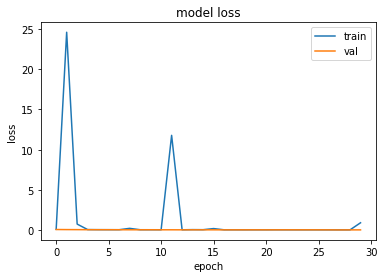

In [115]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [135]:
history.history.keys()

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall', 'lr'])

KeyError: 'precision_1'

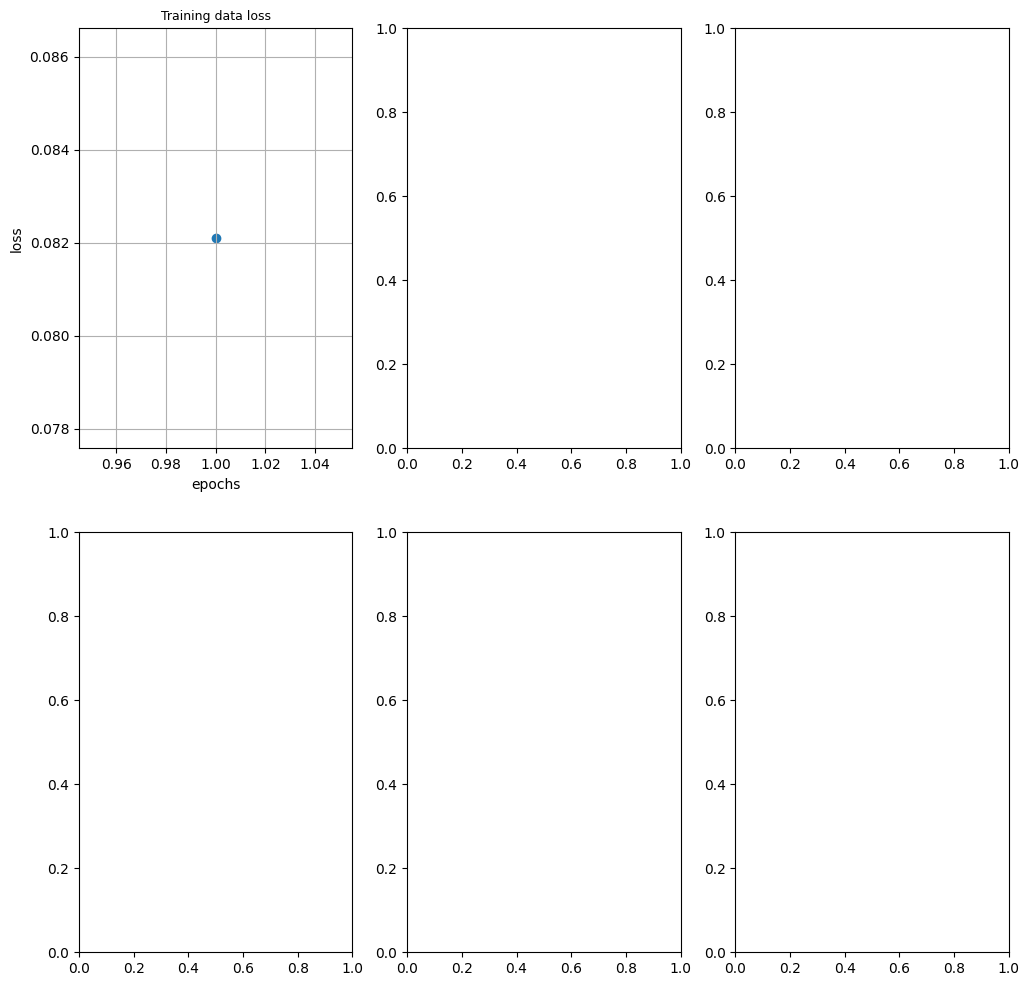

In [136]:
N_epochs=len(history.history['loss'])
fig,ax=plt.subplots(nrows=2,ncols=3,squeeze=False,figsize=(12,12))
plt.sca(ax[0,0])
ax[0,0].scatter(range(1,N_epochs+1),history.history['loss'])

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training data loss",fontsize=9)
plt.grid()

plt.sca(ax[0,1])
ax[0,1].scatter(range(1,N_epochs+1),history.history['precision_1'])
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Precision",fontsize=9)
plt.grid()

plt.sca(ax[0,2])
ax[0,2].scatter(range(1,N_epochs+1),history.history['recall_1'])
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Recall",fontsize=9)
plt.grid()


plt.sca(ax[1,1])
ax[1,1].scatter(range(1,N_epochs+1),history.history['val_precision_1'])
plt.xlabel("epochs")
plt.ylabel("Val_Precision")
plt.title("Val_Precision",fontsize=9)
plt.grid()

plt.sca(ax[1,2])
ax[1,2].scatter(range(1,N_epochs+1),history.history['val_recall_1'])
plt.xlabel("epochs")
plt.ylabel("Val_Recall")
plt.title("Val_Recall",fontsize=9)
plt.grid()
                                                    
plt.sca(ax[1,0])
ax[1,0].scatter(range(1,N_epochs+1),history.history['val_loss'],color="orange")

plt.xlabel("epochs")
plt.ylabel("val_loss")
plt.title("Validation data loss",fontsize=9)
plt.grid()
fig.tight_layout()
plt.show()

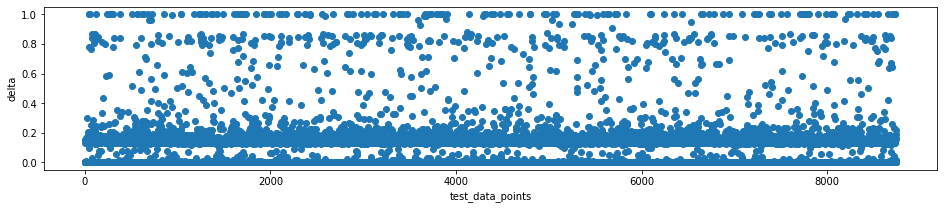

In [129]:
# metrics on test dataset
y_pred=model_rs.predict([test_cust_names,test_wl_names])

y_pred

delta=abs(y_test-y_pred.flatten())

fig,ax=plt.subplots(figsize=(16,3))
plt.scatter(range(len(delta)),delta)
plt.xlabel("test_data_points")
plt.ylabel("delta")
plt.show()

In [130]:
recall=tf.keras.metrics.Recall(thresholds=0.5)


recall.update_state(y_test,y_pred)
recall_value = recall.result().numpy()

recall_value



0.96058786

In [131]:
precision=tf.keras.metrics.Precision(thresholds=0.5)
precision.update_state(y_test,y_pred)
precision_value = precision.result().numpy()

precision_value

0.93396837

In [211]:
# investigation on test datasets for checking the match of predicted value and test value when names of both profiles are same
results_on_test_when_same_name_rs=model_rs.predict([test_cust_names[np.where(y_test==1)],test_wl_names[np.where(y_test==1)]])
pd.DataFrame(results_on_test_when_same_name_rs).describe()

,0
count,4.491000e+03
mean,8.110596e-01
std,1.637117e-01
min,2.061114e-24
25%,8.318145e-01
50%,8.535271e-01
75%,8.641043e-01
max,8.781916e-01


In [212]:
results_on_test_when_same_name_rs,y_pred

(array([[0.8672445 ],
        [0.8498697 ],
        [0.84803736],
        ...,
        [0.78380847],
        [0.8066475 ],
        [0.84023154]], dtype=float32),
 array([1, 0, 1, ..., 1, 1, 0]))

<function matplotlib.pyplot.show(close=None, block=None)>

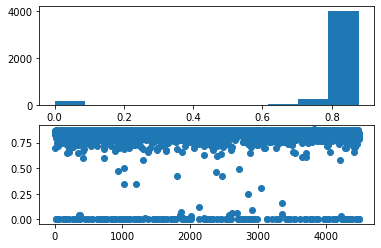

In [213]:
fig,ax=plt.subplots(nrows=2,ncols=1)
#plt.scatter(np.arange(len(results_on_test_when_same_name)),results_on_test_when_same_name)
ax[0].hist(results_on_test_when_same_name_rs,10)
ax[1].scatter(np.arange(len(results_on_test_when_same_name_rs)),results_on_test_when_same_name_rs)

plt.show

In [214]:
# investigation on test datapoints when customer and watchlist name miss-match
results_on_test_when_diff_name_rs=model_rs.predict([test_cust_names[np.where(y_test==0)],test_wl_names[np.where(y_test==0)]])
pd.DataFrame(results_on_test_when_diff_name_rs).describe()

,0
count,4.253000e+03
mean,7.514372e-02
std,2.051771e-01
min,8.579623e-25
25%,2.217060e-13
50%,2.221102e-09
75%,6.318390e-04
max,8.727832e-01


<function matplotlib.pyplot.show(close=None, block=None)>

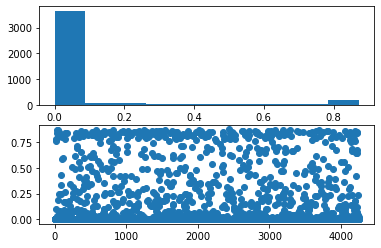

In [215]:
fig,ax=plt.subplots(nrows=2,ncols=1)

ax[0].hist(results_on_test_when_diff_name_rs,10)
ax[1].scatter(np.arange(len(results_on_test_when_diff_name_rs)),results_on_test_when_diff_name_rs)

plt.show

# Bayesian optimization

In [119]:
import keras_tuner

In [120]:
tuner02=keras_tuner.BayesianOptimization(
    build_model,
    objective='val_loss',
    project_name="sid_bo4",
    directory="tuner_06",
    max_trials=10)


INFO:tensorflow:Reloading Tuner from tuner_06/sid_bo4/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner_06/sid_bo4/tuner0.json


In [121]:

tuner02.search([train_cust_names,train_wl_names],y_train, epochs=30, validation_data=([val_cust_names,val_wl_names],y_val),batch_size=500)




INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [122]:
# Get the top 2 models.
models_bo = tuner02.get_best_models(num_models=2)
best_model_bo = models_bo[0]

# retrain the model after Bayesian Optimization

In [123]:
# Get the top 2 hyperparameters.
best_hps_bo = tuner02.get_best_hyperparameters(5)
# Build the model with the best hp.
model_bo = build_model(best_hps_bo[0])

In [133]:
model_path=os.path.join(folder_path,"Siamese_BO.hdf5")
tf.keras.models.save_model(model_bo,model_path)

In [124]:
model_path=os.path.join(folder_path,"mixed_val_loss_bo.hdf5")

In [125]:
keras_callbacks   = [\
      EarlyStopping(monitor='val_loss', min_delta =0.01, patience=25, mode='min'),\
      ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=10, min_lr=0.000001),\
      ModelCheckpoint(filepath=model_path, 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True,
                      save_weights_only=False,
                      mode='min',
                      )]
history = model_bo.fit(x=[train_cust_names,train_wl_names],y=y_train,validation_data=([val_cust_names,val_wl_names],y_val),
                       epochs = 30,
                       verbose = 1,
                       shuffle = True,
                       callbacks=[keras_callbacks])







Epoch 1/30
2214/2214 [==============================] - 26s 11ms/step - loss: 0.1937 - precision_1: 0.7248 - recall_1: 0.9454 - val_loss: 0.1517 - val_precision_1: 0.7951 - val_recall_1: 0.9580

Epoch 00001: val_loss improved from inf to 0.15166, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_bo.hdf5
Epoch 2/30
2214/2214 [==============================] - 23s 10ms/step - loss: 0.1371 - precision_1: 0.7886 - recall_1: 0.9669 - val_loss: 0.1253 - val_precision_1: 0.7882 - val_recall_1: 0.9745

Epoch 00002: val_loss improved from 0.15166 to 0.12530, saving model to /app/dataiku_filesystem_managed/NAMESCREENING_1/X71uZTip/mixed_val_loss_bo.hdf5
Epoch 3/30
2214/2214 [==============================] - 23s 11ms/step - loss: 0.1186 - precision_1: 0.8024 - recall_1: 0.9682 - val_loss: 0.1126 - val_precision_1: 0.8191 - val_recall_1: 0.9656

Epoch 00003: val_loss improved from 0.12530 to 0.11261, saving model to /app/dataiku_filesystem_managed/NAMESCREENI

# Plots from Bayesian Optimization

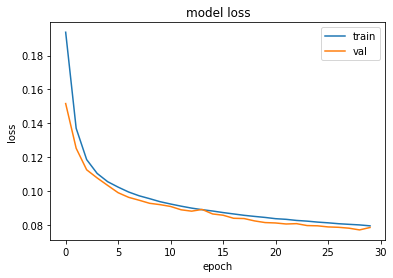

In [126]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

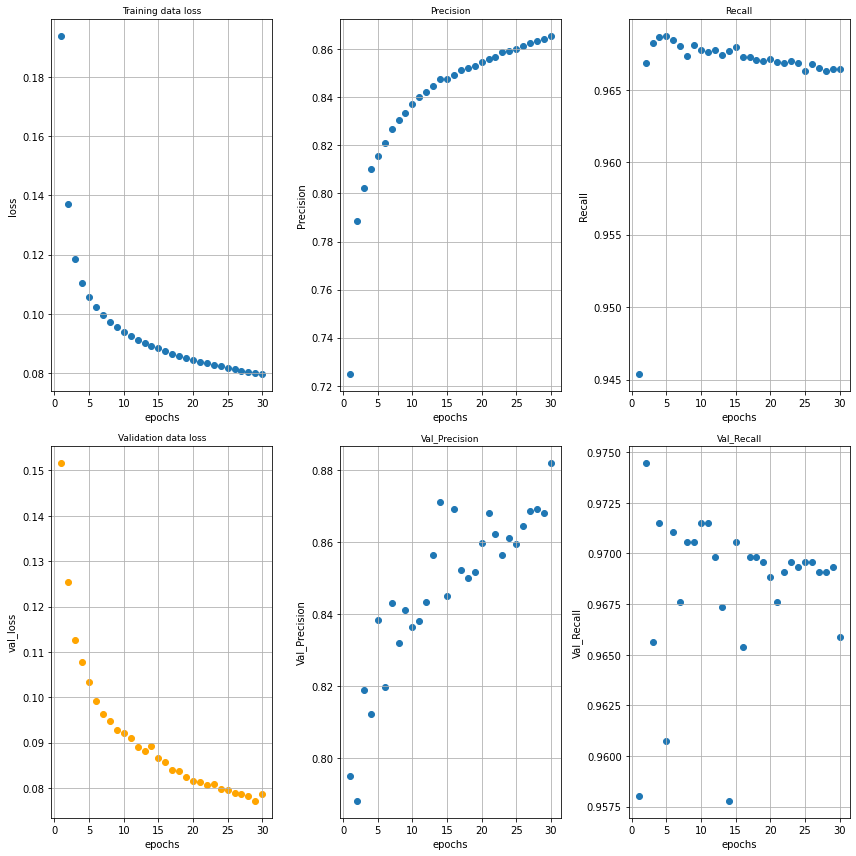

In [127]:
history.history.keys()

N_epochs=len(history.history['loss'])
fig,ax=plt.subplots(nrows=2,ncols=3,squeeze=False,figsize=(12,12))
plt.sca(ax[0,0])
ax[0,0].scatter(range(1,N_epochs+1),history.history['loss'])

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training data loss",fontsize=9)
plt.grid()

plt.sca(ax[0,1])
ax[0,1].scatter(range(1,N_epochs+1),history.history['precision_1'])
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Precision",fontsize=9)
plt.grid()

plt.sca(ax[0,2])
ax[0,2].scatter(range(1,N_epochs+1),history.history['recall_1'])
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Recall",fontsize=9)
plt.grid()


plt.sca(ax[1,1])
ax[1,1].scatter(range(1,N_epochs+1),history.history['val_precision_1'])
plt.xlabel("epochs")
plt.ylabel("Val_Precision")
plt.title("Val_Precision",fontsize=9)
plt.grid()

plt.sca(ax[1,2])
ax[1,2].scatter(range(1,N_epochs+1),history.history['val_recall_1'])
plt.xlabel("epochs")
plt.ylabel("Val_Recall")
plt.title("Val_Recall",fontsize=9)
plt.grid()
                                                    
plt.sca(ax[1,0])
ax[1,0].scatter(range(1,N_epochs+1),history.history['val_loss'],color="orange")

plt.xlabel("epochs")
plt.ylabel("val_loss")
plt.title("Validation data loss",fontsize=9)
plt.grid()
fig.tight_layout()
plt.show()

# Results on test data from BO

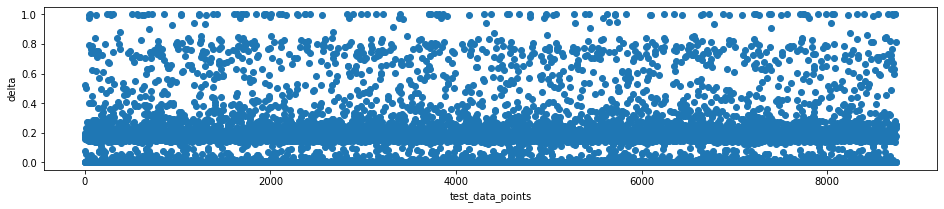

recall_value 0.9596972
precision_value 0.8756603


In [128]:
# metrics on test dataset
y_pred=model_bo.predict([test_cust_names,test_wl_names])

y_pred

delta=abs(y_test-y_pred.flatten())

fig,ax=plt.subplots(figsize=(16,3))
plt.scatter(range(len(delta)),delta)
plt.xlabel("test_data_points")
plt.ylabel("delta")
plt.show()

recall=tf.keras.metrics.Recall(thresholds=0.5)


recall.update_state(y_test,y_pred)
recall_value = recall.result().numpy()

print("recall_value",recall_value)



precision=tf.keras.metrics.Precision(thresholds=0.5)
precision.update_state(y_test,y_pred)
precision_value = precision.result().numpy()

print("precision_value",precision_value)

In [216]:
# investigation on test datasets for checking the match of predicted value and test value when names of both profiles are same
results_on_test_when_same_name_bo=model_bo.predict([test_cust_names[np.where(y_test==1)],test_wl_names[np.where(y_test==1)]])
pd.DataFrame(results_on_test_when_same_name_bo).describe()

,0
count,4.491000e+03
mean,7.712112e-01
std,1.525654e-01
min,1.821692e-08
25%,7.698596e-01
50%,8.127668e-01
75%,8.398400e-01
max,8.672827e-01


In [217]:
results_on_test_when_same_name_bo,y_pred

(array([[0.84191185],
        [0.81254244],
        [0.79854465],
        ...,
        [0.76618415],
        [0.74516195],
        [0.8188886 ]], dtype=float32),
 array([1, 0, 1, ..., 1, 1, 0]))

<function matplotlib.pyplot.show(close=None, block=None)>

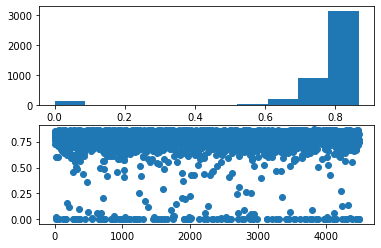

In [218]:
fig,ax=plt.subplots(nrows=2,ncols=1)
#plt.scatter(np.arange(len(results_on_test_when_same_name)),results_on_test_when_same_name)
ax[0].hist(results_on_test_when_same_name_bo,10)
ax[1].scatter(np.arange(len(results_on_test_when_same_name_bo)),results_on_test_when_same_name_bo)

plt.show

In [219]:
# investigation on test datapoints when customer and watchlist name miss-match
results_on_test_when_diff_name_bo=model_bo.predict([test_cust_names[np.where(y_test==0)],test_wl_names[np.where(y_test==0)]])
pd.DataFrame(results_on_test_when_diff_name_bo).describe()

,0
count,4.253000e+03
mean,1.413947e-01
std,2.514066e-01
min,6.554223e-08
25%,1.599789e-04
50%,2.522975e-03
75%,1.391882e-01
max,8.588395e-01


<function matplotlib.pyplot.show(close=None, block=None)>

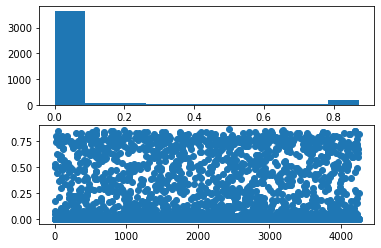

In [220]:
fig,ax=plt.subplots(nrows=2,ncols=1)

ax[0].hist(results_on_test_when_diff_name_rs,10)
ax[1].scatter(np.arange(len(results_on_test_when_diff_name_bo)),results_on_test_when_diff_name_bo)

plt.show

# Hyperband

In [0]:
tuner =keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    directory='new_directory_1',
    #hyperparameters=hp,
    project_name='Hyperband_03'  
)

In [0]:
def build_model(hp):


    rate = 0.2
    tf.random.set_seed(
        11
    )

    rate = 0.2

    output_dim = 100

    #from tensorflow.keras import layers
    from tensorflow.keras import regularizers
    from sklearn.preprocessing import OneHotEncoder
    from tensorflow import one_hot

    #OHE = one_hot(depth=100)
    # Define inputs 
    left_input = Input((51,))
    right_input = Input((51,))

    embedded_l = Embedding(51, output_dim)(left_input)                        #   ------layer 1 (embedding layer)
    embedded_r = Embedding(51, output_dim)(right_input)


    position_embeddings_l = PositionEmbedding(
        sequence_length=51)(embedded_l)
    position_embeddings_r = PositionEmbedding(
        sequence_length=51)(embedded_r)

    embedded_l = embedded_l + position_embeddings_l
    embedded_r = embedded_r + position_embeddings_r

    C_l =tf.keras.layers.Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
                                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                padding = 'same',
                                activation = 'relu',kernel_initializer='he_uniform')(embedded_l)
    
    C_r = tf.keras.layers.Conv1D(    # #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform')(embedded_r)

    C_l = Dense(output_dim)(C_l)                                             # ----------------layer3 ( dense layer)
    C_r = Dense(output_dim)(C_r)

    C_l = embedded_l + C_l                                                   # updating vector
    C_r = embedded_r + C_r

    ##

    C_l = tf.keras.layers.Dropout(rate)(C_l)                                # -----------------layer 4 ( dropout layer)
    C_r = tf.keras.layers.Dropout(rate)(C_r)

    C_l = embedded_l + C_l                                                 # updating vector
    C_r = embedded_r + C_r



    # Generate C_l & C_r with regularization - kernel,bias,activity                  # layer5 ( Conv1d)
    C_l = tf.keras.layers.Conv1D(filters=hp.Int('conv_2_filter', min_value=8, max_value=64, step=8),
        # adding filter size or kernel size
                                 kernel_size=hp.Choice('conv_2_kernel', values = [3,8]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.L2(l2=1e-5),
                                 bias_regularizer=regularizers.L1(1),
                                 activity_regularizer=regularizers.L2(1e-2))(C_l)
    C_r = tf.keras.layers.Conv1D(filters=hp.Int('conv_2_filter', min_value=8, max_value=64, step=8),
        # adding filter size or kernel size
                                 kernel_size=hp.Choice('conv_2_kernel', values = [3,8]),
                                 padding = 'same',
                                 activation = 'relu',kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.L2(l2=1e-5),
                                 bias_regularizer=regularizers.L1(1),
                                 activity_regularizer=regularizers.L2(1e-2))(C_r)
    # Adding dense layer with nuerons equal to 64

    C_l = Dense(output_dim)(C_l)                                                      #layer6 (dense layer)
    C_r = Dense(output_dim)(C_r)

    # Summing the input  embed & output of dense layer 
    C_l = embedded_l + C_l                                                           # update 
    C_r = embedded_r + C_r


    ##


    # Adding dense layer with one nueron. 

    C_l = Dense(1)(C_l)                                                                       # layer7 (dense layer)
    C_r = Dense(1)(C_r)

    # return the cosine similarity on output of left & right sub-network
    y_pred = Dot(axes=(1), normalize=True)([C_l, C_r]) # y_pred == E_w
    # flattening
    y_pred = Flatten()(y_pred)
    # one final neuron with sigmoid as activation.
    y_pred = tf.keras.layers.Dense(1, activation="sigmoid")(y_pred)                           # layer 8 (output layer)

    # define optimizer
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = Model(inputs=[left_input,right_input],outputs=y_pred)
    hp_loss=hp.Choice("loss_name",values=["loss","BCS_loss"])
    if hp_loss=="loss":
    #hp_loss=hp.Choice("loss",values=[loss(),BinaryCrossentropy()])
       model.compile(loss(), optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), \
                                metrics=[tf.keras.metrics.Precision(thresholds=0.5),tf.keras.metrics.Recall(thresholds=0.5)])
    
    #siamese_net_4_mod_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, \
    else:
       
       model.compile(BinaryCrossentropy(), optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), \
                                metrics=[tf.keras.metrics.Precision(thresholds=0.5),tf.keras.metrics.Recall(thresholds=0.5)])

    return model

In [0]:
tuner.search(x_train=[train_cust_names,train_wl_names], y_train=y_train, epochs=50, validation_data=([val_cust_names,val_wl_names],y_val),batch_size=128)




In [0]:
from keras_preprocessing.sequence import pad_sequences

In [0]:
class tok:
    def __init__(self):
        self.maxlen=maxlen
        self.vector=[test_cust_names,test_wl_names]
        self.test=y_test
tok_var=tok()

In [0]:
tok_var.maxlen

file_path=os.path.join(folder_path,"tok_var.sav")
pickle.dump(tok_var,open(file_path,"wb"))
x=pickle.load(open(file_path,"rb"))